In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram

In [2]:
ds = xr.open_mfdataset('../data/lno2/swath_lightning_crf70*.nc', concat_dim='time', combine='nested', parallel=True)

# select pixels with 25*4 strokes during 100 min before the TROPOMI overpass
ds_convection = ds.where((ds['lightning_counts']>25)&(ds['delta']>-100)&(ds['sza']>50), drop=True)

# select pixels with no lightning
ds_noconvection = ds.where((ds['lightning_counts']==0)&(ds['sza']>50), drop=True)

In [3]:
ds_convection.load(), ds_noconvection.load()

(<xarray.Dataset>
 Dimensions:           (time: 209, longitude: 245, latitude: 24)
 Coordinates:
   * longitude         (longitude) float64 -178.8 -178.2 -176.8 ... 172.2 172.8
   * latitude          (latitude) float64 70.25 70.75 71.25 ... 82.75 83.25 84.75
   * time              (time) datetime64[ns] 2019-06-10T06:21:52.336658 ... 20...
 Data variables:
     lightning_counts  (time, longitude, latitude) float64 nan nan ... nan nan
     delta             (time, longitude, latitude) float64 nan nan ... nan nan
     no2_geo           (time, longitude, latitude) float64 nan nan ... nan nan
     sza               (time, longitude, latitude) float64 nan nan ... nan nan
     pcld              (time, longitude, latitude) float64 nan nan ... nan nan
     ptropo            (time, longitude, latitude) float64 nan nan ... nan nan,
 <xarray.Dataset>
 Dimensions:           (time: 3900, longitude: 720, latitude: 60)
 Coordinates:
   * longitude         (longitude) float64 -179.8 -179.2 -178.8 ... 1

In [4]:
ds_convection['sza'].min().values

array(50.00579111)

Because the minimum of SZA is 48 deg, we decide to set three ranges to check the NO2 columns.

- 50 -- 60 N
- 60 -- 70 N
- 70 -- 80 N

## Overview of lightning NO2 distribution

In [6]:
ds_valid = ds_convection['no2_geo'].stack(z=['time','longitude','latitude']).dropna(dim='z')
lon_grid = ds_valid.longitude
lat_grid = ds_valid.latitude

fig, axs = pplt.subplots(proj='npstere')
axs.format(reso='med',
        latlines=10, gridcolor='gray2', gridlinewidth=1, gridalpha=0.6, gridlinestyle='--',
        lonlabels='lrbt', boundinglat=70,
        coast=True, coastcolor='gray8',
        )
axs.scatter(lon_grid, lat_grid)

We choose two regions with lightning to check the above-cloud NO2 with and without lightning
- polluted region (60--180E, 66.5--72N)
- clean region (60--180E, 72--90N)

## above-cloud NO2 over relatively polluted region

In [7]:
def bin_value(ds, pcld_bnd, sza_min, sza_max, lat_min=66.5, lat_max=72):
    # subset to only July
    # ds = ds.loc[dict(time=slice("2020-07-01", "2020-07-31"))]
    pcld = ds['pcld'].stack(z=['time','longitude','latitude']).dropna(dim='z')
    no2_geo = ds['no2_geo'].stack(z=['time','longitude','latitude']).dropna(dim='z')
    sza = ds['sza'].stack(z=['time','longitude','latitude']).dropna(dim='z')

    # select region: lightning NO2 region with some other NO2 emissions
    #   so we can compare their comtributions
    mask = (pcld.longitude>60)&(pcld.longitude<180)&(pcld.latitude>lat_min)&(pcld.latitude<lat_max)&(sza>sza_min)&(sza<sza_max)
    pcld = pcld.where(mask, drop=True)
    no2_geo = no2_geo.where(mask, drop=True)

    n, _ = np.histogram(pcld, bins=pcld_bnd)
    sy, _ = np.histogram(pcld, bins=pcld_bnd, weights=no2_geo)
    sy2, _ = np.histogram(pcld, bins=pcld_bnd, weights=no2_geo*no2_geo)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    
    mean = np.where(n >= 5, mean, np.nan)
    std = np.where(n >= 5, std, np.nan)

    return mean*1e6, std*1e6

In [8]:
pcld_bnd = np.arange(150, 1010, 10)
pcld_center = np.convolve(pcld_bnd, np.ones(2), 'valid') / 2

no2_50_80, std_50_80 = bin_value(ds_convection, pcld_bnd, 50, 80)
no2_50_60, std_50_60 = bin_value(ds_convection, pcld_bnd, 50, 60)
no2_60_70, std_60_70 = bin_value(ds_convection, pcld_bnd, 60, 70)
no2_70_80, std_70_80 = bin_value(ds_convection, pcld_bnd, 70, 80)

no2_50_80_noconvection, std_50_80_noconvection = bin_value(ds_noconvection, pcld_bnd, 50, 80)
no2_50_60_noconvection, std_50_60_noconvection = bin_value(ds_noconvection, pcld_bnd, 50, 60)
no2_60_70_noconvection, std_60_70_noconvection = bin_value(ds_noconvection, pcld_bnd, 60, 70)
no2_70_80_noconvection, std_70_80_noconvection = bin_value(ds_noconvection, pcld_bnd, 70, 80)

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:17: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:17: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/v

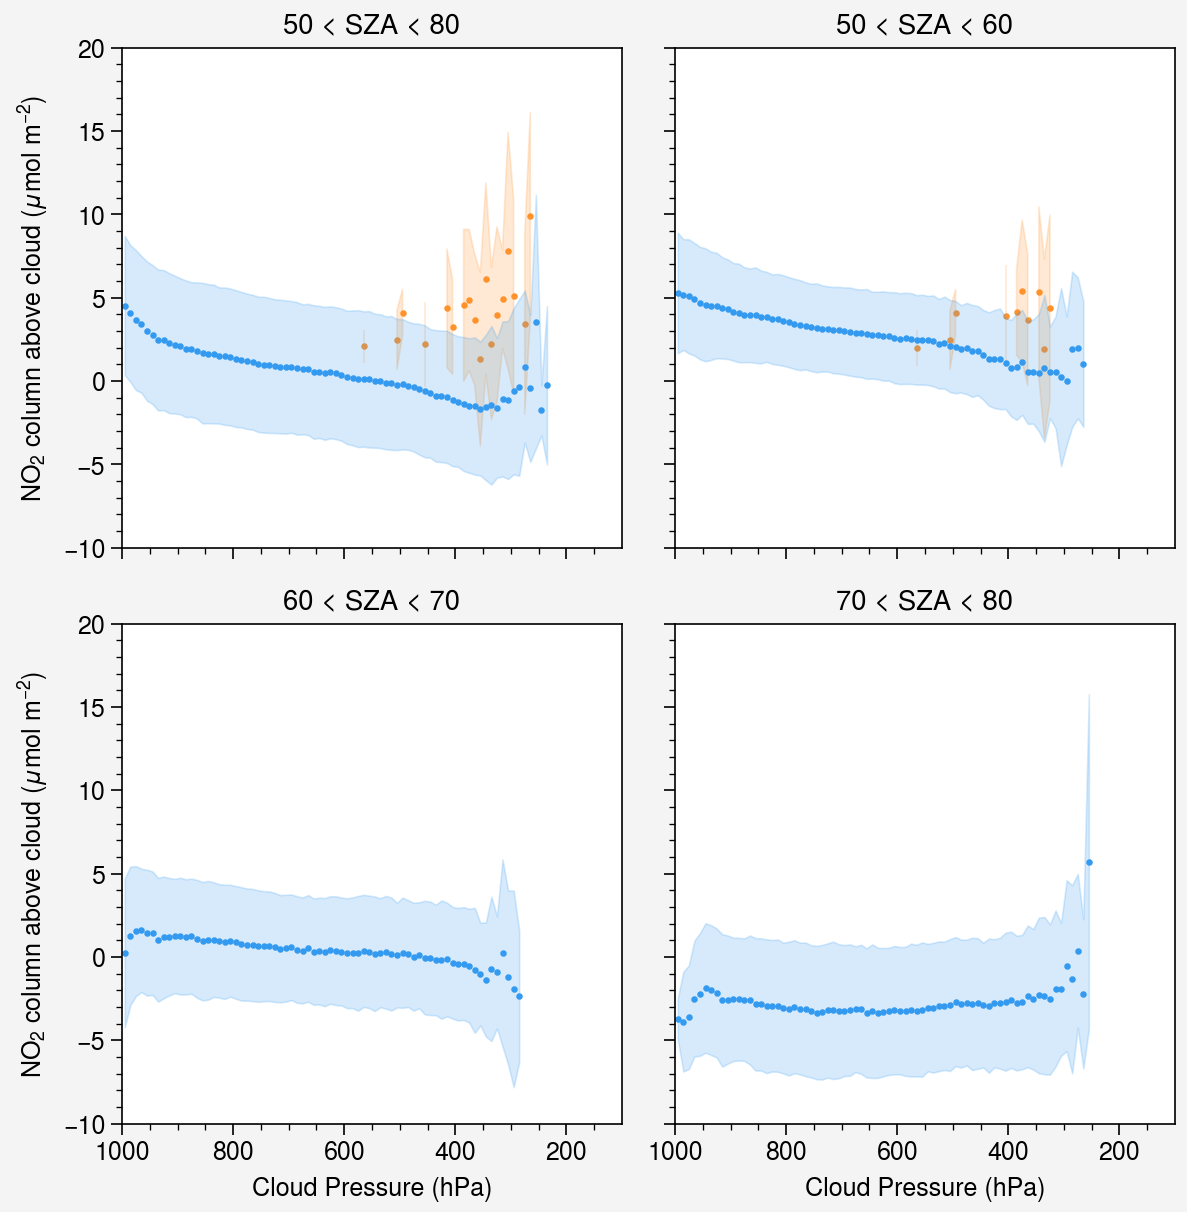

In [9]:
fig, axs = pplt.subplots(nrows=2, ncols=2, span=False)

axs[0].scatter(pcld_center, no2_50_80, markersize=3, c='orange5')
axs[0].fill_between(pcld_center, no2_50_80-std_50_80, no2_50_80+std_50_80, c='orange5', alpha=0.2)
axs[0].scatter(pcld_center, no2_50_80_noconvection, markersize=3, c='blue5')
axs[0].fill_between(pcld_center, no2_50_80_noconvection-std_50_80_noconvection, no2_50_80_noconvection+std_50_80_noconvection, c='blue5', alpha=0.2)

axs[1].scatter(pcld_center, no2_50_60, markersize=3, c='orange5')
axs[1].fill_between(pcld_center, no2_50_60-std_50_60, no2_50_60+std_50_60, c='orange5', alpha=0.2)
axs[1].scatter(pcld_center, no2_50_60_noconvection, markersize=3, c='blue5')
axs[1].fill_between(pcld_center, no2_50_60_noconvection-std_50_60_noconvection, no2_50_60_noconvection+std_50_60_noconvection, c='blue5', alpha=0.2)

axs[2].scatter(pcld_center, no2_60_70, markersize=3, c='orange5')
axs[2].fill_between(pcld_center, no2_60_70-std_60_70, no2_60_70+std_60_70, c='orange5', alpha=0.2)
axs[2].scatter(pcld_center, no2_60_70_noconvection, markersize=3, c='blue5')
axs[2].fill_between(pcld_center, no2_60_70_noconvection-std_60_70_noconvection, no2_60_70_noconvection+std_60_70_noconvection, c='blue5', alpha=0.2)

axs[3].scatter(pcld_center, no2_70_80, markersize=3, c='orange5')
axs[3].fill_between(pcld_center, no2_70_80-std_70_80, no2_70_80+std_70_80, c='orange5', alpha=0.2)
axs[3].scatter(pcld_center, no2_70_80_noconvection, markersize=3, c='blue5')
axs[3].fill_between(pcld_center, no2_70_80_noconvection-std_70_80_noconvection, no2_70_80_noconvection+std_70_80_noconvection, c='blue5', alpha=0.2)


# axs[0].errorbar(pcld_center, no2_50_80, yerr=std_50_80, fmt='o', markersize=3, c='orange5')
# axs[0].errorbar(pcld_center, no2_50_80_noconvection, yerr=std_50_80_noconvection, fmt='o', markersize=3, c='blue5')

# axs[1].errorbar(pcld_center, no2_50_60, yerr=std_50_60, fmt='o', markersize=3, c='orange5')
# axs[1].errorbar(pcld_center, no2_50_60_noconvection, yerr=std_50_60_noconvection, fmt='o', markersize=3, c='blue5')

# axs[2].errorbar(pcld_center, no2_60_70, yerr=std_60_70, fmt='o', markersize=3, c='orange5')
# axs[2].errorbar(pcld_center, no2_60_70_noconvection, yerr=std_60_70_noconvection, fmt='o', markersize=3, c='blue5')

# axs[3].errorbar(pcld_center, no2_70_80, yerr=std_70_80, fmt='o', markersize=3, c='orange5')
# axs[3].errorbar(pcld_center, no2_70_80_noconvection, yerr=std_70_80_noconvection, fmt='o', markersize=3, c='blue5')

axs.format(title=['50 < SZA < 80', '50 < SZA < 60', '60 < SZA < 70', '70 < SZA < 80'],
xlim=(1000, 100), ylim=(-10, 20), xlabel='Cloud Pressure (hPa)', 
ylabel='NO$_2$ column above cloud ($\mu$mol m$^{-2}$)',
grid=False)

## above-cloud NO2 over really clean region

In [10]:
no2_50_80_clean, std_50_80_clean = bin_value(ds_convection, pcld_bnd, 50, 80, lat_min=72, lat_max=90)
no2_50_60_clean, std_50_60_clean = bin_value(ds_convection, pcld_bnd, 50, 60, lat_min=72, lat_max=90)
no2_60_70_clean, std_60_70_clean = bin_value(ds_convection, pcld_bnd, 60, 70, lat_min=72, lat_max=90)
no2_70_80_clean, std_70_80_clean = bin_value(ds_convection, pcld_bnd, 70, 80, lat_min=72, lat_max=90)

no2_50_80_noconvection_clean, std_50_80_noconvection_clean = bin_value(ds_noconvection, pcld_bnd, 50, 80, lat_min=72, lat_max=90)
no2_50_60_noconvection_clean, std_50_60_noconvection_clean = bin_value(ds_noconvection, pcld_bnd, 50, 60, lat_min=72, lat_max=90)
no2_60_70_noconvection_clean, std_60_70_noconvection_clean = bin_value(ds_noconvection, pcld_bnd, 60, 70, lat_min=72, lat_max=90)
no2_70_80_noconvection_clean, std_70_80_noconvection_clean = bin_value(ds_noconvection, pcld_bnd, 70, 80, lat_min=72, lat_max=90)

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:17: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:17: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_13827/3038387217.py:18: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/v

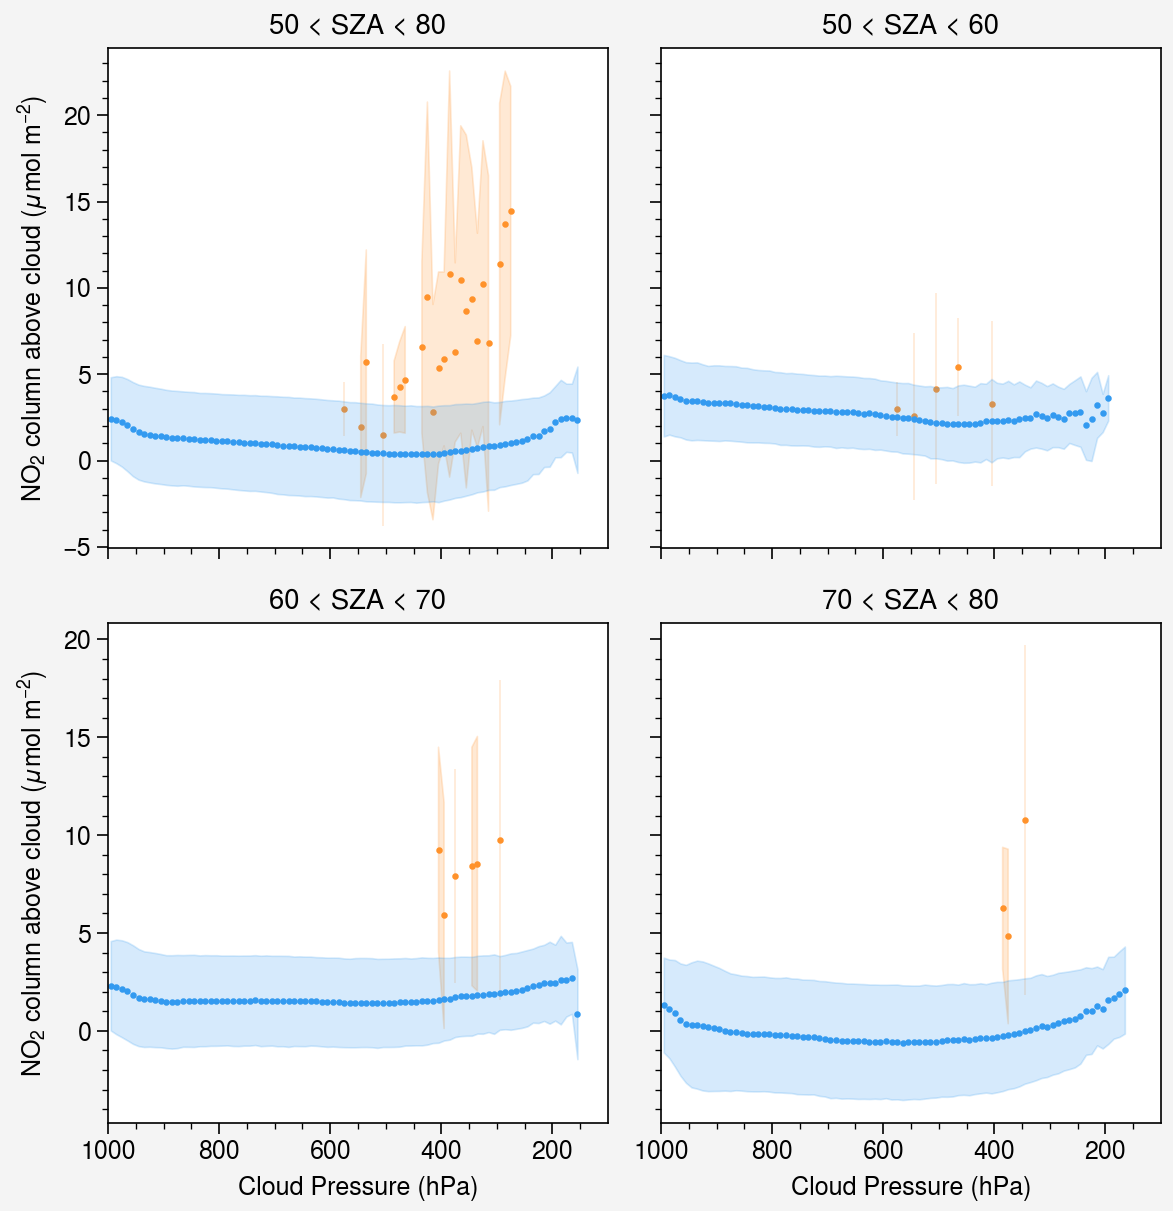

In [11]:
fig, axs = pplt.subplots(nrows=2, ncols=2, span=False)

axs[0].scatter(pcld_center, no2_50_80_clean, markersize=3, c='orange5')
axs[0].fill_between(pcld_center, no2_50_80_clean-std_50_80_clean, no2_50_80_clean+std_50_80_clean, c='orange5', alpha=0.2)
axs[0].scatter(pcld_center, no2_50_80_noconvection_clean, markersize=3, c='blue5')
axs[0].fill_between(pcld_center, no2_50_80_noconvection_clean-std_50_80_noconvection_clean, no2_50_80_noconvection_clean+std_50_80_noconvection_clean, c='blue5', alpha=0.2)

axs[1].scatter(pcld_center, no2_50_60_clean, markersize=3, c='orange5')
axs[1].fill_between(pcld_center, no2_50_60_clean-std_50_60_clean, no2_50_60_clean+std_50_60_clean, c='orange5', alpha=0.2)
axs[1].scatter(pcld_center, no2_50_60_noconvection_clean, markersize=3, c='blue5')
axs[1].fill_between(pcld_center, no2_50_60_noconvection_clean-std_50_60_noconvection_clean, no2_50_60_noconvection_clean+std_50_60_noconvection_clean, c='blue5', alpha=0.2)

axs[2].scatter(pcld_center, no2_60_70_clean, markersize=3, c='orange5')
axs[2].fill_between(pcld_center, no2_60_70_clean-std_60_70_clean, no2_60_70_clean+std_60_70_clean, c='orange5', alpha=0.2)
axs[2].scatter(pcld_center, no2_60_70_noconvection_clean, markersize=3, c='blue5')
axs[2].fill_between(pcld_center, no2_60_70_noconvection_clean-std_60_70_noconvection_clean, no2_60_70_noconvection_clean+std_60_70_noconvection_clean, c='blue5', alpha=0.2)

axs[3].scatter(pcld_center, no2_70_80_clean, markersize=3, c='orange5')
axs[3].fill_between(pcld_center, no2_70_80_clean-std_70_80_clean, no2_70_80_clean+std_70_80_clean, c='orange5', alpha=0.2)
axs[3].scatter(pcld_center, no2_70_80_noconvection_clean, markersize=3, c='blue5')
axs[3].fill_between(pcld_center, no2_70_80_noconvection_clean-std_70_80_noconvection_clean, no2_70_80_noconvection_clean+std_70_80_noconvection_clean, c='blue5', alpha=0.2)

axs.format(title=['50 < SZA < 80', '50 < SZA < 60', '60 < SZA < 70', '70 < SZA < 80'],
xlim=(1000, 100), xlabel='Cloud Pressure (hPa)', 
ylabel='NO$_2$ column above cloud ($\mu$mol m$^{-2}$)',
grid=False)

## Summary

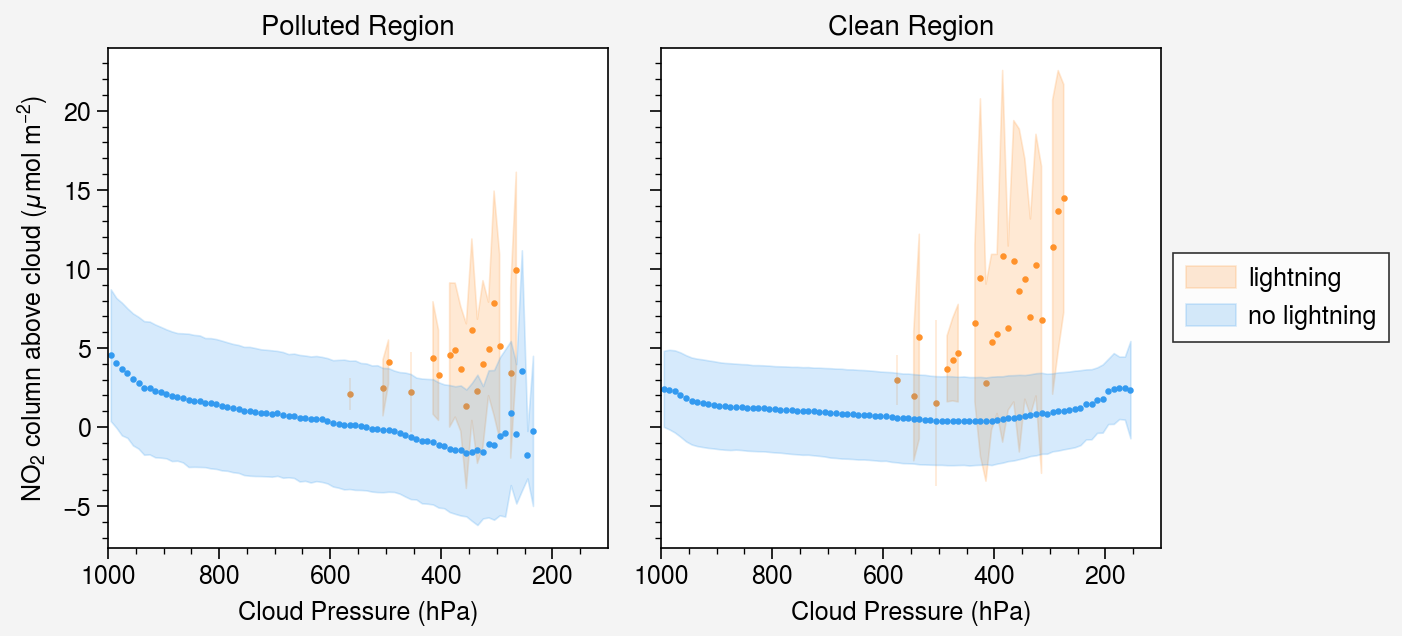

In [12]:
fig, axs = pplt.subplots(ncols=2, span=False)

axs[0].scatter(pcld_center, no2_50_80, markersize=3, c='orange5')
axs[0].fill_between(pcld_center, no2_50_80-std_50_80, no2_50_80+std_50_80, c='orange5', alpha=0.2)
axs[0].scatter(pcld_center, no2_50_80_noconvection, markersize=3, c='blue5')
axs[0].fill_between(pcld_center, no2_50_80_noconvection-std_50_80_noconvection, no2_50_80_noconvection+std_50_80_noconvection, c='blue5', alpha=0.2)

axs[1].scatter(pcld_center, no2_50_80_clean, markersize=3, c='orange5')
f1 = axs[1].fill_between(pcld_center, no2_50_80_clean-std_50_80_clean, no2_50_80_clean+std_50_80_clean, c='orange5', alpha=0.2, label='lightning')
axs[1].scatter(pcld_center, no2_50_80_noconvection_clean, markersize=3, c='blue5')
f2 = axs[1].fill_between(pcld_center, no2_50_80_noconvection_clean-std_50_80_noconvection_clean, no2_50_80_noconvection_clean+std_50_80_noconvection_clean, c='blue5', alpha=0.2, label='no lightning')

axs.format(title=['Polluted Region', 'Clean Region'],
xlim=(1000, 100), xlabel='Cloud Pressure (hPa)', 
ylabel='NO$_2$ column above cloud ($\mu$mol m$^{-2}$)',
grid=False)

axs[1].legend([f1, f2], loc='r', ncols=1)
fig.savefig('../figures/no2_above_cld.pdf')

- Higher surface NO2 over the polluted region
- Lightning NO2 dominates the upper-tropospheric NO2

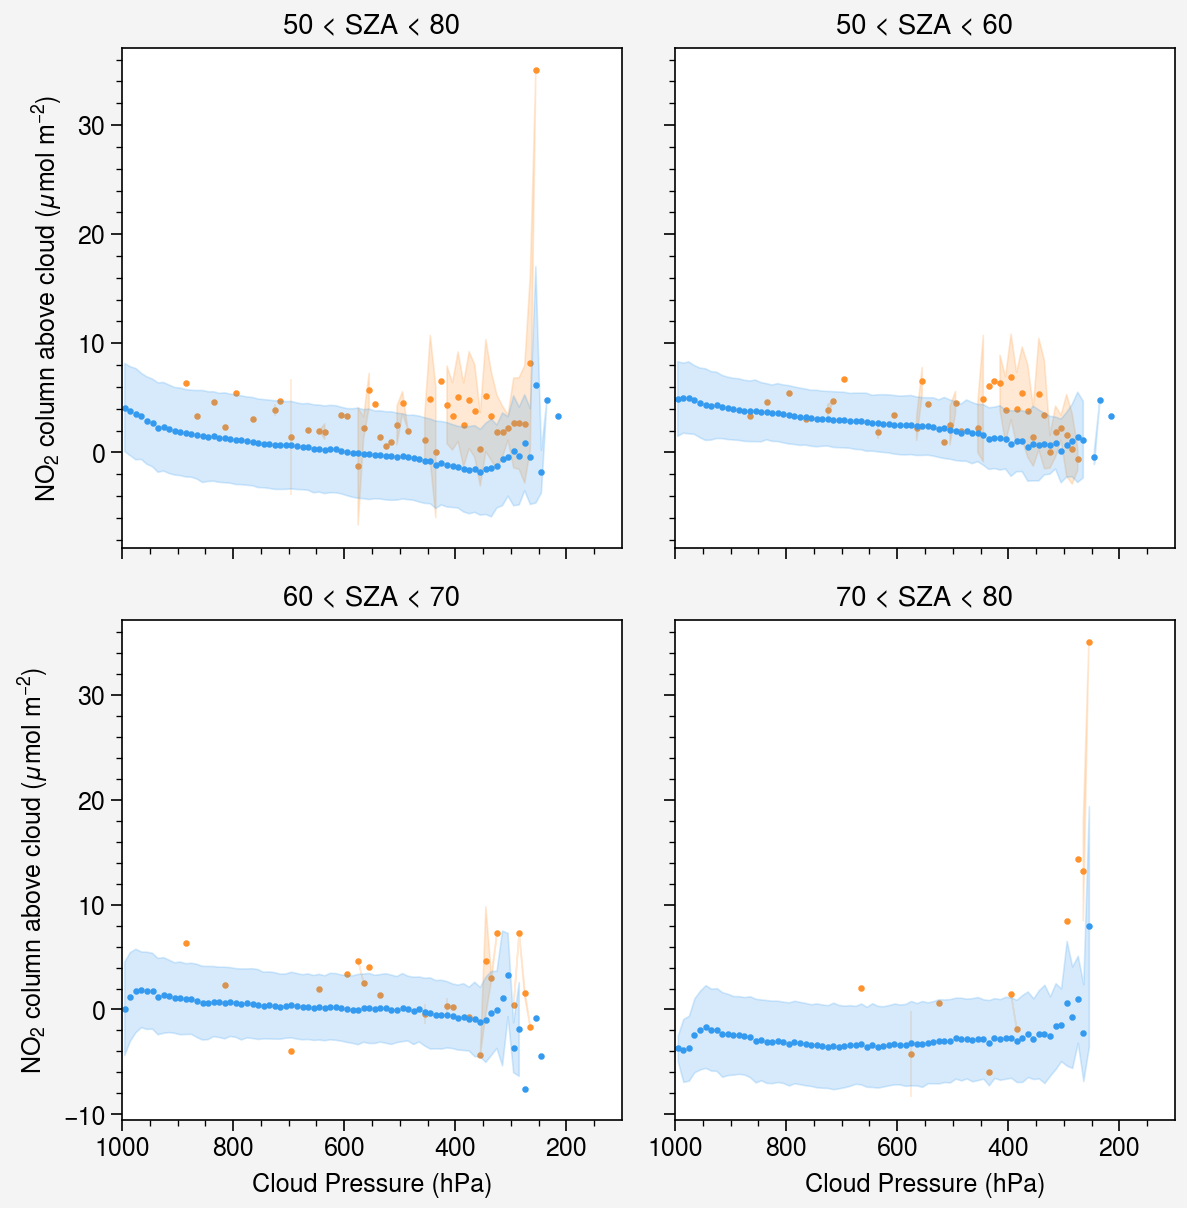

In [14]:
fig, axs = pplt.subplots(nrows=2, ncols=2, span=False)

axs[0].scatter(pcld_center, no2_50_80, markersize=3, c='orange5')
axs[0].fill_between(pcld_center, no2_50_80-std_50_80, no2_50_80+std_50_80, c='orange5', alpha=0.2)
axs[0].scatter(pcld_center, no2_50_80_noconvection, markersize=3, c='blue5')
axs[0].fill_between(pcld_center, no2_50_80_noconvection-std_50_80_noconvection, no2_50_80_noconvection+std_50_80_noconvection, c='blue5', alpha=0.2)

axs[1].scatter(pcld_center, no2_50_60, markersize=3, c='orange5')
axs[1].fill_between(pcld_center, no2_50_60-std_50_60, no2_50_60+std_50_60, c='orange5', alpha=0.2)
axs[1].scatter(pcld_center, no2_50_60_noconvection, markersize=3, c='blue5')
axs[1].fill_between(pcld_center, no2_50_60_noconvection-std_50_60_noconvection, no2_50_60_noconvection+std_50_60_noconvection, c='blue5', alpha=0.2)

axs[2].scatter(pcld_center, no2_60_70, markersize=3, c='orange5')
axs[2].fill_between(pcld_center, no2_60_70-std_60_70, no2_60_70+std_60_70, c='orange5', alpha=0.2)
axs[2].scatter(pcld_center, no2_60_70_noconvection, markersize=3, c='blue5')
axs[2].fill_between(pcld_center, no2_60_70_noconvection-std_60_70_noconvection, no2_60_70_noconvection+std_60_70_noconvection, c='blue5', alpha=0.2)

axs[3].scatter(pcld_center, no2_70_80, markersize=3, c='orange5')
axs[3].fill_between(pcld_center, no2_70_80-std_70_80, no2_70_80+std_70_80, c='orange5', alpha=0.2)
axs[3].scatter(pcld_center, no2_70_80_noconvection, markersize=3, c='blue5')
axs[3].fill_between(pcld_center, no2_70_80_noconvection-std_70_80_noconvection, no2_70_80_noconvection+std_70_80_noconvection, c='blue5', alpha=0.2)


# axs[0].errorbar(pcld_center, no2_50_80, yerr=std_50_80, fmt='o', markersize=3, c='orange5')
# axs[0].errorbar(pcld_center, no2_50_80_noconvection, yerr=std_50_80_noconvection, fmt='o', markersize=3, c='blue5')

# axs[1].errorbar(pcld_center, no2_50_60, yerr=std_50_60, fmt='o', markersize=3, c='orange5')
# axs[1].errorbar(pcld_center, no2_50_60_noconvection, yerr=std_50_60_noconvection, fmt='o', markersize=3, c='blue5')

# axs[2].errorbar(pcld_center, no2_60_70, yerr=std_60_70, fmt='o', markersize=3, c='orange5')
# axs[2].errorbar(pcld_center, no2_60_70_noconvection, yerr=std_60_70_noconvection, fmt='o', markersize=3, c='blue5')

# axs[3].errorbar(pcld_center, no2_70_80, yerr=std_70_80, fmt='o', markersize=3, c='orange5')
# axs[3].errorbar(pcld_center, no2_70_80_noconvection, yerr=std_70_80_noconvection, fmt='o', markersize=3, c='blue5')

axs.format(title=['50 < SZA < 80', '50 < SZA < 60', '60 < SZA < 70', '70 < SZA < 80'],
xlim=(1000, 100), xlabel='Cloud Pressure (hPa)', 
ylabel='NO$_2$ column above cloud ($\mu$mol m$^{-2}$)',
grid=False)